In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 csroh3h4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/330 [00:01<07:00,  1.28s/it]

  1%|▉                                                                                                                                                   | 2/330 [00:01<03:25,  1.60it/s]

  1%|█▎                                                                                                                                                  | 3/330 [00:01<02:16,  2.39it/s]

  1%|█▊                                                                                                                                                  | 4/330 [00:01<01:44,  3.12it/s]

  2%|██▏                                                                                                                                                 | 5/330 [00:01<01:26,  3.76it/s]

  2%|██▋                                                                                                                                                 | 6/330 [00:02<01:15,  4.28it/s]

  2%|███▏                                                                                                                                                | 7/330 [00:02<01:08,  4.70it/s]

  2%|███▌                                                                                                                                                | 8/330 [00:02<01:04,  5.02it/s]

  3%|████                                                                                                                                                | 9/330 [00:02<01:01,  5.26it/s]

  3%|████▍                                                                                                                                              | 10/330 [00:02<00:58,  5.43it/s]

  3%|████▉                                                                                                                                              | 11/330 [00:02<00:57,  5.56it/s]

  4%|█████▎                                                                                                                                             | 12/330 [00:03<00:56,  5.65it/s]

  4%|█████▊                                                                                                                                             | 13/330 [00:03<00:55,  5.71it/s]

  4%|██████▏                                                                                                                                            | 14/330 [00:03<00:54,  5.75it/s]

  5%|██████▋                                                                                                                                            | 15/330 [00:03<00:54,  5.79it/s]

  5%|███████▏                                                                                                                                           | 16/330 [00:03<00:54,  5.81it/s]

  5%|███████▌                                                                                                                                           | 17/330 [00:04<00:53,  5.83it/s]

  5%|████████                                                                                                                                           | 18/330 [00:04<00:53,  5.84it/s]

  6%|████████▍                                                                                                                                          | 19/330 [00:04<00:53,  5.85it/s]

  6%|████████▉                                                                                                                                          | 20/330 [00:04<00:52,  5.86it/s]

  6%|█████████▎                                                                                                                                         | 21/330 [00:04<00:52,  5.86it/s]

  7%|█████████▊                                                                                                                                         | 22/330 [00:04<00:52,  5.86it/s]

  7%|██████████▏                                                                                                                                        | 23/330 [00:05<00:52,  5.86it/s]

  7%|██████████▋                                                                                                                                        | 24/330 [00:05<00:52,  5.86it/s]

  8%|███████████▏                                                                                                                                       | 25/330 [00:05<00:51,  5.87it/s]

  8%|███████████▌                                                                                                                                       | 26/330 [00:05<00:51,  5.87it/s]

  8%|████████████                                                                                                                                       | 27/330 [00:05<00:51,  5.87it/s]

  8%|████████████▍                                                                                                                                      | 28/330 [00:05<00:51,  5.87it/s]

  9%|████████████▉                                                                                                                                      | 29/330 [00:06<00:51,  5.87it/s]

  9%|█████████████▎                                                                                                                                     | 30/330 [00:06<00:51,  5.86it/s]

  9%|█████████████▊                                                                                                                                     | 31/330 [00:06<00:50,  5.87it/s]

 10%|██████████████▎                                                                                                                                    | 32/330 [00:06<00:50,  5.87it/s]

 10%|██████████████▋                                                                                                                                    | 33/330 [00:06<00:50,  5.88it/s]

 10%|███████████████▏                                                                                                                                   | 34/330 [00:06<00:50,  5.88it/s]

 11%|███████████████▌                                                                                                                                   | 35/330 [00:07<00:50,  5.88it/s]

 11%|████████████████                                                                                                                                   | 36/330 [00:07<00:49,  5.88it/s]

 11%|████████████████▍                                                                                                                                  | 37/330 [00:07<00:49,  5.88it/s]

 12%|████████████████▉                                                                                                                                  | 38/330 [00:07<00:49,  5.88it/s]

 12%|█████████████████▎                                                                                                                                 | 39/330 [00:07<00:49,  5.87it/s]

 12%|█████████████████▊                                                                                                                                 | 40/330 [00:07<00:49,  5.87it/s]

 12%|██████████████████▎                                                                                                                                | 41/330 [00:08<00:49,  5.87it/s]

 13%|██████████████████▋                                                                                                                                | 42/330 [00:08<00:49,  5.87it/s]

 13%|███████████████████▏                                                                                                                               | 43/330 [00:08<00:48,  5.87it/s]

 13%|███████████████████▌                                                                                                                               | 44/330 [00:08<00:48,  5.87it/s]

 14%|████████████████████                                                                                                                               | 45/330 [00:08<00:48,  5.88it/s]

 14%|████████████████████▍                                                                                                                              | 46/330 [00:08<00:48,  5.87it/s]

 14%|████████████████████▉                                                                                                                              | 47/330 [00:09<00:48,  5.87it/s]

 15%|█████████████████████▍                                                                                                                             | 48/330 [00:09<00:48,  5.87it/s]

 15%|█████████████████████▊                                                                                                                             | 49/330 [00:09<00:47,  5.87it/s]

 15%|██████████████████████▎                                                                                                                            | 50/330 [00:09<00:47,  5.87it/s]

 15%|██████████████████████▋                                                                                                                            | 51/330 [00:09<00:47,  5.87it/s]

 16%|███████████████████████▏                                                                                                                           | 52/330 [00:09<00:47,  5.87it/s]

 16%|███████████████████████▌                                                                                                                           | 53/330 [00:10<00:47,  5.86it/s]

 16%|████████████████████████                                                                                                                           | 54/330 [00:10<00:47,  5.87it/s]

 17%|████████████████████████▌                                                                                                                          | 55/330 [00:10<00:46,  5.87it/s]

 17%|████████████████████████▉                                                                                                                          | 56/330 [00:10<00:46,  5.87it/s]

 17%|█████████████████████████▍                                                                                                                         | 57/330 [00:10<00:46,  5.87it/s]

 18%|█████████████████████████▊                                                                                                                         | 58/330 [00:10<00:46,  5.87it/s]

 18%|██████████████████████████▎                                                                                                                        | 59/330 [00:11<00:46,  5.87it/s]

 18%|██████████████████████████▋                                                                                                                        | 60/330 [00:11<00:46,  5.86it/s]

 18%|███████████████████████████▏                                                                                                                       | 61/330 [00:11<00:45,  5.87it/s]

 19%|███████████████████████████▌                                                                                                                       | 62/330 [00:11<00:45,  5.87it/s]

 19%|████████████████████████████                                                                                                                       | 63/330 [00:11<00:45,  5.87it/s]

 19%|████████████████████████████▌                                                                                                                      | 64/330 [00:12<00:45,  5.87it/s]

 20%|████████████████████████████▉                                                                                                                      | 65/330 [00:12<00:45,  5.87it/s]

 20%|█████████████████████████████▍                                                                                                                     | 66/330 [00:12<00:44,  5.87it/s]

 20%|█████████████████████████████▊                                                                                                                     | 67/330 [00:12<00:44,  5.86it/s]

 21%|██████████████████████████████▎                                                                                                                    | 68/330 [00:12<00:44,  5.86it/s]

 21%|██████████████████████████████▋                                                                                                                    | 69/330 [00:12<00:44,  5.87it/s]

 21%|███████████████████████████████▏                                                                                                                   | 70/330 [00:13<00:44,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                   | 71/330 [00:13<00:44,  5.87it/s]

 22%|████████████████████████████████                                                                                                                   | 72/330 [00:13<00:43,  5.87it/s]

 22%|████████████████████████████████▌                                                                                                                  | 73/330 [00:13<00:43,  5.87it/s]

 22%|████████████████████████████████▉                                                                                                                  | 74/330 [00:13<00:43,  5.86it/s]

 23%|█████████████████████████████████▍                                                                                                                 | 75/330 [00:13<00:43,  5.86it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 76/330 [00:14<00:43,  5.87it/s]

 23%|██████████████████████████████████▎                                                                                                                | 77/330 [00:14<00:43,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                                | 78/330 [00:14<00:42,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                               | 79/330 [00:14<00:42,  5.87it/s]

 24%|███████████████████████████████████▋                                                                                                               | 80/330 [00:14<00:42,  5.87it/s]

 25%|████████████████████████████████████                                                                                                               | 81/330 [00:14<00:42,  5.86it/s]

 25%|████████████████████████████████████▌                                                                                                              | 82/330 [00:15<00:42,  5.87it/s]

 25%|████████████████████████████████████▉                                                                                                              | 83/330 [00:15<00:42,  5.87it/s]

 25%|█████████████████████████████████████▍                                                                                                             | 84/330 [00:15<00:41,  5.87it/s]

 26%|█████████████████████████████████████▊                                                                                                             | 85/330 [00:15<00:41,  5.87it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 86/330 [00:15<00:41,  5.87it/s]

 26%|██████████████████████████████████████▊                                                                                                            | 87/330 [00:15<00:41,  5.87it/s]

 27%|███████████████████████████████████████▏                                                                                                           | 88/330 [00:16<00:41,  5.86it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 89/330 [00:16<00:41,  5.87it/s]

 27%|████████████████████████████████████████                                                                                                           | 90/330 [00:16<00:40,  5.87it/s]

 28%|████████████████████████████████████████▌                                                                                                          | 91/330 [00:16<00:40,  5.87it/s]

 28%|████████████████████████████████████████▉                                                                                                          | 92/330 [00:16<00:40,  5.87it/s]

 28%|█████████████████████████████████████████▍                                                                                                         | 93/330 [00:16<00:40,  5.87it/s]

 28%|█████████████████████████████████████████▊                                                                                                         | 94/330 [00:17<00:40,  5.87it/s]

 29%|██████████████████████████████████████████▎                                                                                                        | 95/330 [00:17<00:40,  5.87it/s]

 29%|██████████████████████████████████████████▊                                                                                                        | 96/330 [00:17<00:39,  5.87it/s]

 29%|███████████████████████████████████████████▏                                                                                                       | 97/330 [00:17<00:39,  5.87it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 98/330 [00:17<00:39,  5.87it/s]

 30%|████████████████████████████████████████████                                                                                                       | 99/330 [00:17<00:39,  5.87it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 100/330 [00:18<00:39,  5.87it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 101/330 [00:18<00:38,  5.87it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 102/330 [00:18<00:38,  5.87it/s]

 31%|█████████████████████████████████████████████▌                                                                                                    | 103/330 [00:18<00:38,  5.87it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 104/330 [00:18<00:38,  5.87it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 105/330 [00:18<00:38,  5.87it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 106/330 [00:19<00:38,  5.87it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 107/330 [00:19<00:37,  5.87it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 108/330 [00:19<00:37,  5.86it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 109/330 [00:19<00:37,  5.86it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 110/330 [00:19<00:37,  5.86it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 111/330 [00:20<00:37,  5.87it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 112/330 [00:20<00:37,  5.87it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 113/330 [00:20<00:36,  5.87it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 114/330 [00:20<00:36,  5.87it/s]

 35%|██████████████████████████████████████████████████▉                                                                                               | 115/330 [00:20<00:36,  5.87it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 116/330 [00:20<00:36,  5.86it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 117/330 [00:21<00:36,  5.86it/s]

 36%|████████████████████████████████████████████████████▏                                                                                             | 118/330 [00:21<00:36,  5.87it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 119/330 [00:21<00:35,  5.87it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 120/330 [00:21<00:35,  5.87it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 121/330 [00:21<00:35,  5.87it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                            | 122/330 [00:21<00:35,  5.87it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 123/330 [00:22<00:35,  5.86it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 124/330 [00:22<00:35,  5.86it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                          | 125/330 [00:22<00:34,  5.86it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 126/330 [00:22<00:34,  5.86it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                         | 127/330 [00:22<00:34,  5.87it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 128/330 [00:22<00:34,  5.87it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 129/330 [00:23<00:34,  5.87it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 130/330 [00:23<00:34,  5.86it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                        | 131/330 [00:23<00:33,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 132/330 [00:23<00:33,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 133/330 [00:23<00:33,  5.86it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                      | 134/330 [00:23<00:33,  5.86it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 135/330 [00:24<00:33,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 136/330 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                     | 137/330 [00:24<00:32,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 138/330 [00:24<00:32,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 139/330 [00:24<00:32,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 140/330 [00:24<00:32,  5.86it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 141/330 [00:25<00:32,  5.86it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 142/330 [00:25<00:32,  5.87it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 143/330 [00:25<00:31,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 144/330 [00:25<00:31,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 145/330 [00:25<00:31,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 146/330 [00:25<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 147/330 [00:26<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 148/330 [00:26<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 149/330 [00:26<00:30,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 150/330 [00:26<00:30,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 151/330 [00:26<00:30,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 152/330 [00:27<00:30,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 153/330 [00:27<00:30,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 154/330 [00:27<00:29,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 155/330 [00:27<00:29,  5.87it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 156/330 [00:27<00:29,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 157/330 [00:27<00:29,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 158/330 [00:28<00:29,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 159/330 [00:28<00:29,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                           | 160/330 [00:28<00:28,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 161/330 [00:28<00:28,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 162/330 [00:28<00:28,  5.87it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 163/330 [00:28<00:28,  5.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 164/330 [00:29<00:28,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 165/330 [00:29<00:28,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 166/330 [00:29<00:27,  5.87it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 167/330 [00:29<00:27,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                       | 168/330 [00:29<00:27,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 169/330 [00:29<00:27,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 170/330 [00:30<00:27,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 171/330 [00:30<00:27,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 172/330 [00:30<00:26,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 173/330 [00:30<00:26,  5.87it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 174/330 [00:30<00:26,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 175/330 [00:30<00:26,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 176/330 [00:31<00:26,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 177/330 [00:31<00:26,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 178/330 [00:31<00:25,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 179/330 [00:31<00:25,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 180/330 [00:31<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 181/330 [00:31<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 182/330 [00:32<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 183/330 [00:32<00:25,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 184/330 [00:32<00:24,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 185/330 [00:32<00:24,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 186/330 [00:32<00:24,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 187/330 [00:32<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 188/330 [00:33<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 189/330 [00:33<00:24,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 190/330 [00:33<00:23,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 191/330 [00:33<00:23,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 192/330 [00:33<00:23,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 193/330 [00:33<00:23,  5.86it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 194/330 [00:34<00:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 195/330 [00:34<00:22,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 196/330 [00:34<00:22,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 197/330 [00:34<00:22,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 198/330 [00:34<00:22,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 199/330 [00:35<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 200/330 [00:35<00:22,  5.86it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 201/330 [00:35<00:21,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 202/330 [00:35<00:21,  5.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 203/330 [00:35<00:21,  5.86it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 204/330 [00:35<00:21,  5.86it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 205/330 [00:36<00:21,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 206/330 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 207/330 [00:36<00:20,  5.86it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 208/330 [00:36<00:20,  5.86it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 209/330 [00:36<00:20,  5.86it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 210/330 [00:36<00:20,  5.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 211/330 [00:37<00:20,  5.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 212/330 [00:37<00:20,  5.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 213/330 [00:37<00:19,  5.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 214/330 [00:37<00:19,  5.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 215/330 [00:37<00:19,  5.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 216/330 [00:37<00:19,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 217/330 [00:38<00:19,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 218/330 [00:38<00:19,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 219/330 [00:38<00:18,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 220/330 [00:38<00:18,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 221/330 [00:38<00:18,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 222/330 [00:38<00:18,  5.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 223/330 [00:39<00:18,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                               | 224/330 [00:39<00:18,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 225/330 [00:39<00:17,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 226/330 [00:39<00:17,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 227/330 [00:39<00:17,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 228/330 [00:39<00:17,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 229/330 [00:40<00:17,  5.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 230/330 [00:40<00:17,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 231/330 [00:40<00:16,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 232/330 [00:40<00:16,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 233/330 [00:40<00:16,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 234/330 [00:40<00:16,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 235/330 [00:41<00:16,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 236/330 [00:41<00:16,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 237/330 [00:41<00:15,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 238/330 [00:41<00:15,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 239/330 [00:41<00:15,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 240/330 [00:42<00:15,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 241/330 [00:42<00:15,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 242/330 [00:42<00:15,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 243/330 [00:42<00:14,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 244/330 [00:42<00:14,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 245/330 [00:42<00:14,  5.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 246/330 [00:43<00:14,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 247/330 [00:43<00:14,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 248/330 [00:43<00:13,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 249/330 [00:43<00:13,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 250/330 [00:43<00:13,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 251/330 [00:43<00:13,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 252/330 [00:44<00:13,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 253/330 [00:44<00:13,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 254/330 [00:44<00:12,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 255/330 [00:44<00:12,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 256/330 [00:44<00:12,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 257/330 [00:44<00:12,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 258/330 [00:45<00:12,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 259/330 [00:45<00:12,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 260/330 [00:45<00:11,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 261/330 [00:45<00:11,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 262/330 [00:45<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 263/330 [00:45<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 264/330 [00:46<00:11,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 265/330 [00:46<00:11,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 266/330 [00:46<00:10,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 267/330 [00:46<00:10,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 268/330 [00:46<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 269/330 [00:46<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 270/330 [00:47<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 271/330 [00:47<00:10,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 272/330 [00:47<00:09,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 273/330 [00:47<00:09,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 274/330 [00:47<00:09,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 275/330 [00:47<00:09,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 276/330 [00:48<00:09,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 277/330 [00:48<00:09,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 278/330 [00:48<00:08,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 279/330 [00:48<00:08,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 280/330 [00:48<00:08,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 281/330 [00:48<00:08,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 282/330 [00:49<00:08,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 283/330 [00:49<00:08,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 284/330 [00:49<00:07,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 285/330 [00:49<00:07,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 286/330 [00:49<00:07,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 287/330 [00:50<00:07,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 288/330 [00:50<00:07,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 289/330 [00:50<00:06,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 290/330 [00:50<00:06,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 291/330 [00:50<00:06,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 292/330 [00:50<00:06,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 293/330 [00:51<00:06,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 294/330 [00:51<00:06,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 295/330 [00:51<00:05,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 296/330 [00:51<00:05,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 297/330 [00:51<00:05,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 298/330 [00:51<00:05,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 299/330 [00:52<00:05,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 300/330 [00:52<00:05,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 301/330 [00:52<00:04,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 302/330 [00:52<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 303/330 [00:52<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 304/330 [00:52<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 305/330 [00:53<00:04,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 306/330 [00:53<00:04,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 307/330 [00:53<00:03,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 308/330 [00:53<00:03,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 309/330 [00:53<00:03,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 310/330 [00:53<00:03,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 311/330 [00:54<00:03,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 312/330 [00:54<00:03,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 313/330 [00:54<00:02,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 314/330 [00:54<00:02,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 315/330 [00:54<00:02,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 316/330 [00:54<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 317/330 [00:55<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 318/330 [00:55<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 319/330 [00:55<00:01,  5.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 320/330 [00:55<00:01,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 321/330 [00:55<00:01,  5.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 322/330 [00:55<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 323/330 [00:56<00:01,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 324/330 [00:56<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 325/330 [00:56<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 326/330 [00:56<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 327/330 [00:56<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 328/330 [00:57<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 329/330 [00:57<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:57<00:00,  5.76it/s]

train - OK


  0%|                                                                                                                                                             | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                 | 1/42 [00:00<00:11,  3.46it/s]

  5%|███████                                                                                                                                              | 2/42 [00:00<00:08,  4.55it/s]

  7%|██████████▋                                                                                                                                          | 3/42 [00:00<00:07,  5.08it/s]

 10%|██████████████▏                                                                                                                                      | 4/42 [00:00<00:07,  5.37it/s]

 12%|█████████████████▋                                                                                                                                   | 5/42 [00:00<00:06,  5.55it/s]

 14%|█████████████████████▎                                                                                                                               | 6/42 [00:01<00:06,  5.66it/s]

 17%|████████████████████████▊                                                                                                                            | 7/42 [00:01<00:06,  5.73it/s]

 19%|████████████████████████████▍                                                                                                                        | 8/42 [00:01<00:05,  5.78it/s]

 21%|███████████████████████████████▉                                                                                                                     | 9/42 [00:01<00:05,  5.81it/s]

 24%|███████████████████████████████████▏                                                                                                                | 10/42 [00:01<00:05,  5.84it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 11/42 [00:01<00:05,  5.85it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 12/42 [00:02<00:05,  5.86it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 13/42 [00:02<00:04,  5.86it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 14/42 [00:02<00:04,  5.86it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 15/42 [00:02<00:04,  5.86it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 16/42 [00:02<00:04,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                        | 17/42 [00:03<00:04,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 18/42 [00:03<00:04,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                 | 19/42 [00:03<00:03,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 20/42 [00:03<00:03,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 21/42 [00:03<00:03,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 22/42 [00:03<00:03,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                   | 23/42 [00:04<00:03,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                               | 24/42 [00:04<00:03,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                            | 25/42 [00:04<00:02,  5.85it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26/42 [00:04<00:02,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 27/42 [00:04<00:02,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 28/42 [00:04<00:02,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29/42 [00:05<00:02,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 30/42 [00:05<00:02,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 31/42 [00:05<00:01,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 32/42 [00:05<00:01,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 33/42 [00:05<00:01,  5.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 34/42 [00:05<00:01,  5.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 35/42 [00:06<00:01,  5.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 36/42 [00:06<00:01,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 37/42 [00:06<00:00,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 38/42 [00:06<00:00,  5.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 39/42 [00:06<00:00,  5.85it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40/42 [00:06<00:00,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:07<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.81it/s]

val - OK


  0%|                                                                                                                                                             | 0/23 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                              | 1/23 [00:00<00:06,  3.32it/s]

  9%|████████████▉                                                                                                                                        | 2/23 [00:00<00:04,  4.46it/s]

 13%|███████████████████▍                                                                                                                                 | 3/23 [00:00<00:03,  5.02it/s]

 17%|█████████████████████████▉                                                                                                                           | 4/23 [00:00<00:03,  5.33it/s]

 22%|████████████████████████████████▍                                                                                                                    | 5/23 [00:00<00:03,  5.52it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 6/23 [00:01<00:03,  5.65it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 7/23 [00:01<00:02,  5.73it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 8/23 [00:01<00:02,  5.78it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 9/23 [00:01<00:02,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 10/23 [00:01<00:02,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 11/23 [00:01<00:02,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 12/23 [00:02<00:01,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                                | 13/23 [00:02<00:01,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                          | 14/23 [00:02<00:01,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 15/23 [00:02<00:01,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 16/23 [00:02<00:01,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 17/23 [00:03<00:01,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18/23 [00:03<00:00,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 19/23 [00:03<00:00,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20/23 [00:03<00:00,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21/23 [00:03<00:00,  5.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 22/23 [00:03<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.60it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                   | 1/138 [00:00<00:41,  3.29it/s]

  1%|██▏                                                                                                                                                 | 2/138 [00:00<00:30,  4.43it/s]

  2%|███▏                                                                                                                                                | 3/138 [00:00<00:27,  4.99it/s]

  3%|████▎                                                                                                                                               | 4/138 [00:00<00:25,  5.31it/s]

  4%|█████▎                                                                                                                                              | 5/138 [00:00<00:24,  5.50it/s]

  4%|██████▍                                                                                                                                             | 6/138 [00:01<00:23,  5.62it/s]

  5%|███████▌                                                                                                                                            | 7/138 [00:01<00:22,  5.71it/s]

  6%|████████▌                                                                                                                                           | 8/138 [00:01<00:22,  5.76it/s]

  7%|█████████▋                                                                                                                                          | 9/138 [00:01<00:22,  5.81it/s]

  7%|██████████▋                                                                                                                                        | 10/138 [00:01<00:21,  5.84it/s]

  8%|███████████▋                                                                                                                                       | 11/138 [00:02<00:21,  5.86it/s]

  9%|████████████▊                                                                                                                                      | 12/138 [00:02<00:21,  5.87it/s]

  9%|█████████████▊                                                                                                                                     | 13/138 [00:02<00:21,  5.88it/s]

 10%|██████████████▉                                                                                                                                    | 14/138 [00:02<00:21,  5.88it/s]

 11%|███████████████▉                                                                                                                                   | 15/138 [00:02<00:20,  5.89it/s]

 12%|█████████████████                                                                                                                                  | 16/138 [00:02<00:20,  5.89it/s]

 12%|██████████████████                                                                                                                                 | 17/138 [00:03<00:20,  5.89it/s]

 13%|███████████████████▏                                                                                                                               | 18/138 [00:03<00:20,  5.88it/s]

 14%|████████████████████▏                                                                                                                              | 19/138 [00:03<00:20,  5.88it/s]

 14%|█████████████████████▎                                                                                                                             | 20/138 [00:03<00:20,  5.88it/s]

 15%|██████████████████████▎                                                                                                                            | 21/138 [00:03<00:19,  5.88it/s]

 16%|███████████████████████▍                                                                                                                           | 22/138 [00:03<00:19,  5.88it/s]

 17%|████████████████████████▌                                                                                                                          | 23/138 [00:04<00:19,  5.88it/s]

 17%|█████████████████████████▌                                                                                                                         | 24/138 [00:04<00:19,  5.88it/s]

 18%|██████████████████████████▋                                                                                                                        | 25/138 [00:04<00:19,  5.88it/s]

 19%|███████████████████████████▋                                                                                                                       | 26/138 [00:04<00:19,  5.87it/s]

 20%|████████████████████████████▊                                                                                                                      | 27/138 [00:04<00:18,  5.87it/s]

 20%|█████████████████████████████▊                                                                                                                     | 28/138 [00:04<00:18,  5.87it/s]

 21%|██████████████████████████████▉                                                                                                                    | 29/138 [00:05<00:18,  5.87it/s]

 22%|███████████████████████████████▉                                                                                                                   | 30/138 [00:05<00:18,  5.87it/s]

 22%|█████████████████████████████████                                                                                                                  | 31/138 [00:05<00:18,  5.87it/s]

 23%|██████████████████████████████████                                                                                                                 | 32/138 [00:05<00:18,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                               | 33/138 [00:05<00:17,  5.87it/s]

 25%|████████████████████████████████████▏                                                                                                              | 34/138 [00:05<00:17,  5.87it/s]

 25%|█████████████████████████████████████▎                                                                                                             | 35/138 [00:06<00:17,  5.87it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 36/138 [00:06<00:17,  5.87it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 37/138 [00:06<00:17,  5.87it/s]

 28%|████████████████████████████████████████▍                                                                                                          | 38/138 [00:06<00:17,  5.87it/s]

 28%|█████████████████████████████████████████▌                                                                                                         | 39/138 [00:06<00:16,  5.88it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 40/138 [00:06<00:16,  5.89it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 41/138 [00:07<00:16,  5.89it/s]

 30%|████████████████████████████████████████████▋                                                                                                      | 42/138 [00:07<00:16,  5.89it/s]

 31%|█████████████████████████████████████████████▊                                                                                                     | 43/138 [00:07<00:16,  5.90it/s]

 32%|██████████████████████████████████████████████▊                                                                                                    | 44/138 [00:07<00:15,  5.90it/s]

 33%|███████████████████████████████████████████████▉                                                                                                   | 45/138 [00:07<00:15,  5.90it/s]

 33%|█████████████████████████████████████████████████                                                                                                  | 46/138 [00:07<00:15,  5.90it/s]

 34%|██████████████████████████████████████████████████                                                                                                 | 47/138 [00:08<00:15,  5.90it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 48/138 [00:08<00:15,  5.90it/s]

 36%|████████████████████████████████████████████████████▏                                                                                              | 49/138 [00:08<00:15,  5.89it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 50/138 [00:08<00:14,  5.89it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 51/138 [00:08<00:14,  5.89it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                           | 52/138 [00:08<00:14,  5.89it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 53/138 [00:09<00:14,  5.89it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 54/138 [00:09<00:14,  5.89it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 55/138 [00:09<00:14,  5.89it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 56/138 [00:09<00:13,  5.89it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 57/138 [00:09<00:13,  5.89it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 58/138 [00:09<00:13,  5.89it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 59/138 [00:10<00:13,  5.89it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 60/138 [00:10<00:13,  5.89it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 61/138 [00:10<00:13,  5.89it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 62/138 [00:10<00:12,  5.90it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 63/138 [00:10<00:12,  5.90it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 64/138 [00:11<00:12,  5.90it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 65/138 [00:11<00:12,  5.91it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 66/138 [00:11<00:12,  5.91it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 67/138 [00:11<00:12,  5.91it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 68/138 [00:11<00:11,  5.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 69/138 [00:11<00:11,  5.91it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 70/138 [00:12<00:11,  5.90it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 71/138 [00:12<00:11,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 72/138 [00:12<00:11,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 73/138 [00:12<00:11,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 74/138 [00:12<00:10,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 75/138 [00:12<00:10,  5.88it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/138 [00:13<00:10,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 77/138 [00:13<00:10,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 78/138 [00:13<00:10,  5.89it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 79/138 [00:13<00:10,  5.90it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 80/138 [00:13<00:09,  5.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 81/138 [00:13<00:09,  5.90it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 82/138 [00:14<00:09,  5.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 83/138 [00:14<00:09,  5.91it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 84/138 [00:14<00:09,  5.91it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 85/138 [00:14<00:08,  5.91it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86/138 [00:14<00:08,  5.91it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87/138 [00:14<00:08,  5.91it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88/138 [00:15<00:08,  5.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89/138 [00:15<00:08,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 90/138 [00:15<00:08,  5.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 91/138 [00:15<00:07,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 92/138 [00:15<00:07,  5.90it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 93/138 [00:15<00:07,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 94/138 [00:16<00:07,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 95/138 [00:16<00:07,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 96/138 [00:16<00:07,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 97/138 [00:16<00:06,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 98/138 [00:16<00:06,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 99/138 [00:16<00:06,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 100/138 [00:17<00:06,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 101/138 [00:17<00:06,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 102/138 [00:17<00:06,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 103/138 [00:17<00:05,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 104/138 [00:17<00:05,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 105/138 [00:17<00:05,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 106/138 [00:18<00:05,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 107/138 [00:18<00:05,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 108/138 [00:18<00:05,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 109/138 [00:18<00:04,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 110/138 [00:18<00:04,  5.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 111/138 [00:18<00:04,  5.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 112/138 [00:19<00:04,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 113/138 [00:19<00:04,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 114/138 [00:19<00:04,  5.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 115/138 [00:19<00:03,  5.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 116/138 [00:19<00:03,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 117/138 [00:20<00:03,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 118/138 [00:20<00:03,  5.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 119/138 [00:20<00:03,  5.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 120/138 [00:20<00:03,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 121/138 [00:20<00:02,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 122/138 [00:20<00:02,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 123/138 [00:21<00:02,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 124/138 [00:21<00:02,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 125/138 [00:21<00:02,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 126/138 [00:21<00:02,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 127/138 [00:21<00:01,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 128/138 [00:21<00:01,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 129/138 [00:22<00:01,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 130/138 [00:22<00:01,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 131/138 [00:22<00:01,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 132/138 [00:22<00:01,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 133/138 [00:22<00:00,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 134/138 [00:22<00:00,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 135/138 [00:23<00:00,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 136/138 [00:23<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 137/138 [00:23<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:23<00:00,  5.86it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                  | 1/100 [00:00<00:14,  7.00it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:13,  7.02it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:13,  7.03it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:13,  7.04it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:13,  7.04it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:13,  7.05it/s]

  7%|██████████▎                                                                                                                                         | 7/100 [00:00<00:13,  7.04it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:01<00:13,  7.05it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:01<00:12,  7.05it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:01<00:12,  7.05it/s]

 11%|████████████████▏                                                                                                                                  | 11/100 [00:01<00:12,  7.05it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:01<00:12,  7.05it/s]

 13%|███████████████████                                                                                                                                | 13/100 [00:01<00:12,  7.05it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:01<00:12,  7.06it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:02<00:12,  7.06it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:02<00:11,  7.06it/s]

 17%|████████████████████████▉                                                                                                                          | 17/100 [00:02<00:11,  7.06it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:02<00:11,  7.06it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:02<00:11,  7.06it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:02<00:11,  7.06it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:02<00:11,  7.06it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:03<00:11,  7.06it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:03<00:10,  7.06it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:03<00:10,  7.06it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:03<00:10,  7.06it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:03<00:10,  7.06it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:03<00:10,  7.06it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:03<00:10,  7.06it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:04<00:10,  7.06it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:04<00:09,  7.06it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 31/100 [00:04<00:09,  7.06it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:04<00:09,  7.06it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:04<00:09,  7.04it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:04<00:09,  7.03it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:04<00:09,  7.02it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:05<00:09,  7.02it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 37/100 [00:05<00:08,  7.01it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:05<00:08,  7.01it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:05<00:08,  7.01it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:05<00:08,  7.00it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 41/100 [00:05<00:08,  6.99it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:05<00:08,  6.99it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 43/100 [00:06<00:08,  7.00it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:06<00:08,  7.00it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:06<00:07,  7.00it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:06<00:07,  7.00it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 47/100 [00:06<00:07,  7.00it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:06<00:07,  7.01it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:06<00:07,  7.00it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:07<00:07,  7.00it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:07<00:06,  7.00it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:07<00:06,  7.00it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 53/100 [00:07<00:06,  7.00it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:07<00:06,  7.00it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:07<00:06,  7.00it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:07<00:06,  7.00it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:08<00:06,  7.00it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:08<00:05,  7.00it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:08<00:05,  7.00it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:08<00:05,  7.00it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:08<00:05,  7.00it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:08<00:05,  7.00it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:08<00:05,  7.00it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:09<00:05,  7.00it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:09<00:05,  7.00it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:09<00:04,  7.00it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 67/100 [00:09<00:04,  7.00it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:09<00:04,  7.00it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:09<00:04,  7.00it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:09<00:04,  7.00it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 71/100 [00:10<00:04,  7.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:10<00:03,  7.00it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:10<00:03,  7.00it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:10<00:03,  7.00it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:10<00:03,  7.00it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:10<00:03,  7.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 77/100 [00:10<00:03,  7.00it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:11<00:03,  7.01it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:11<00:02,  7.00it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:11<00:02,  7.00it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:11<00:02,  7.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:11<00:02,  7.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 83/100 [00:11<00:02,  7.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:11<00:02,  7.00it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:12<00:02,  7.00it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:12<00:01,  7.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:12<00:01,  7.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:12<00:01,  7.00it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:12<00:01,  7.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:12<00:01,  7.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [00:12<00:01,  7.01it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:13<00:01,  7.01it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:13<00:00,  7.00it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:13<00:00,  7.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:13<00:00,  7.00it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  7.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:13<00:00,  7.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:13<00:00,  7.00it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  7.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(42153, 1, 64, 64) (42153, 512) (42153, 3584) (42153, 1, 64, 64) (42153,)
(5269, 1, 64, 64) (5269, 512) (5269, 3584) (5269, 1, 64, 64) (5269,)
(2928, 1, 64, 64) (2928, 512) (2928, 3584) (2928, 1, 64, 64) (2928,)
(17568, 1, 64, 64) (17568, 512) (17568, 3584) (17568, 1, 64, 64) (17568,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)


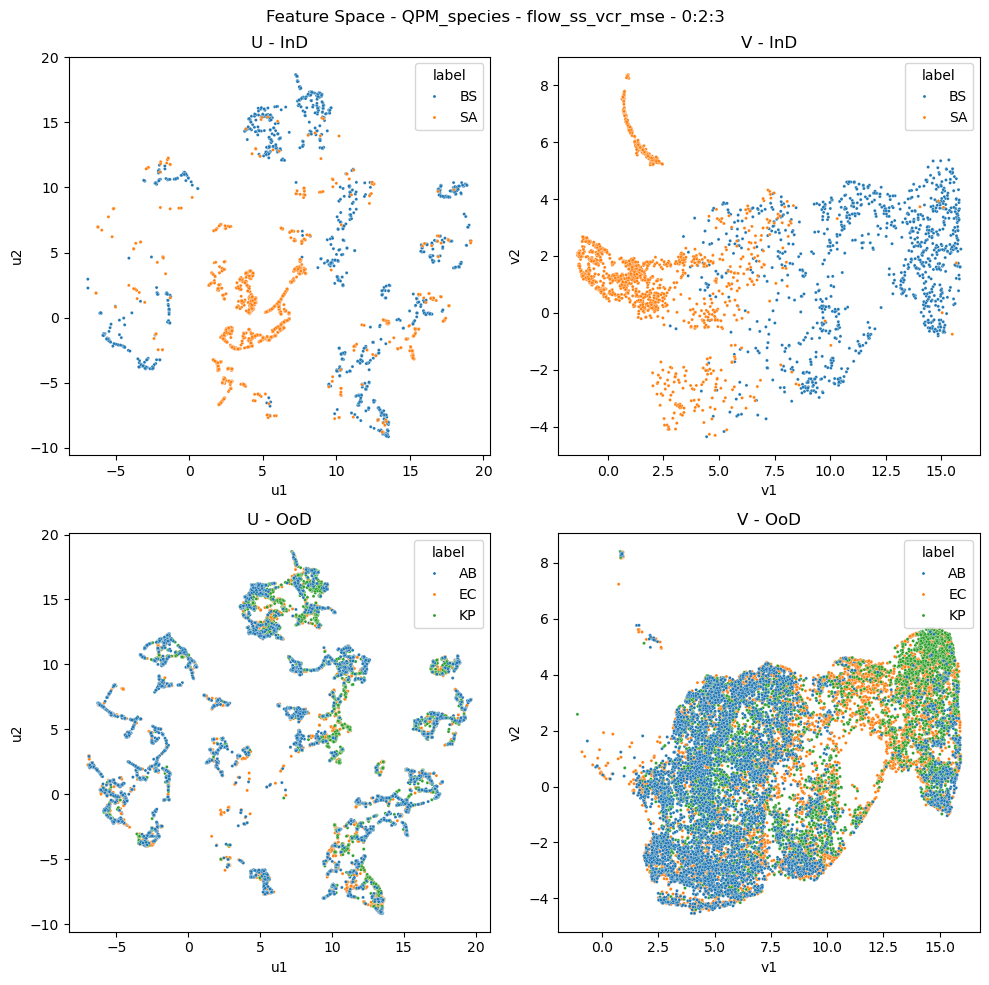

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

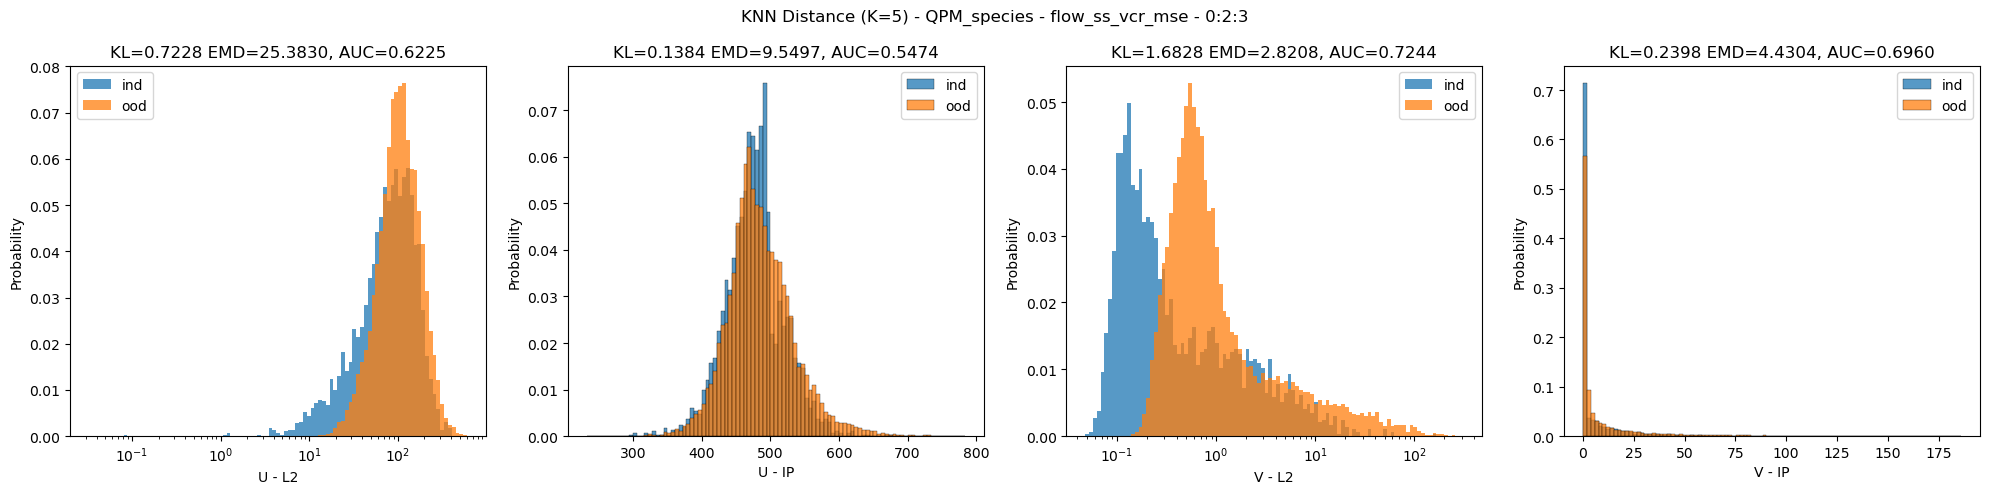

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

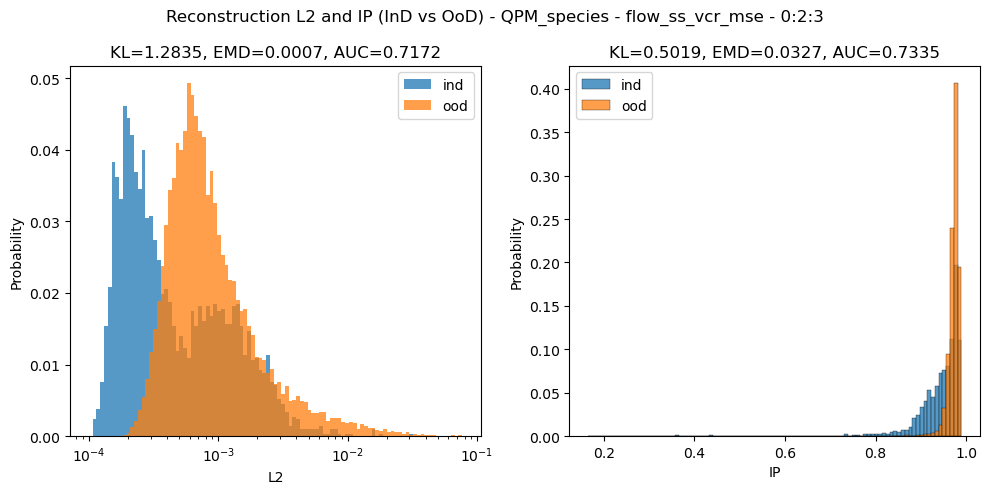

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.743055 0.7650029 1.2581391 1.3692685
22.684193 0.6822756 1.1462799 1.2093445
22.846087 0.82170707 1.4317567 1.4968147
23.332415 1.2745484 2.1549459 2.3168063
34.56032 0.92047364 58.11449 0.7491844


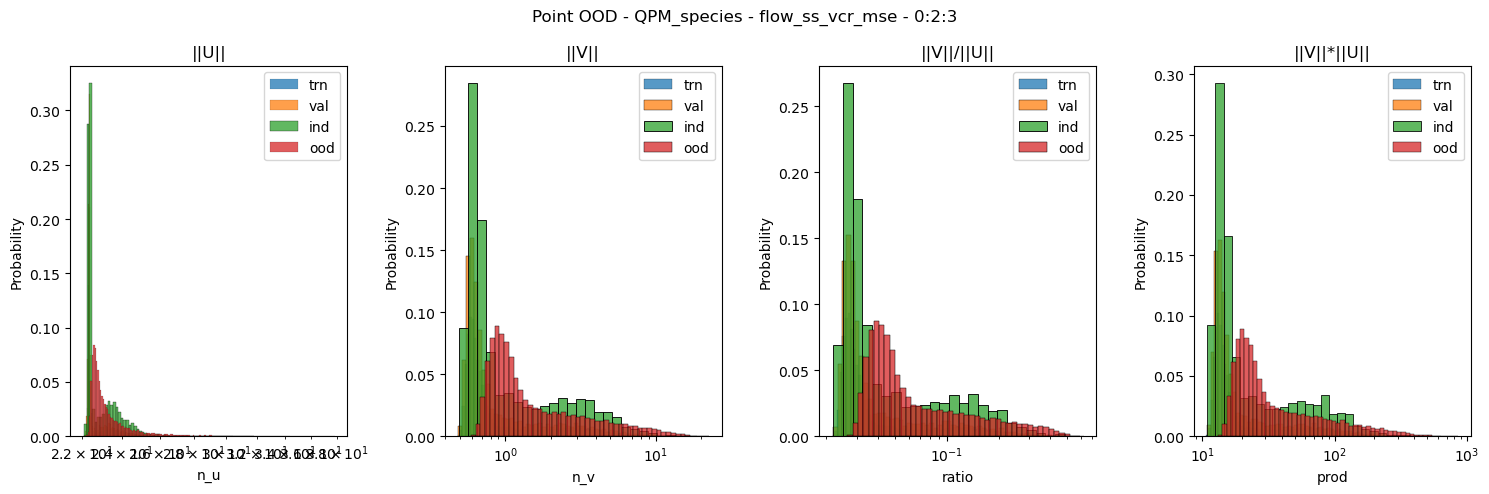

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


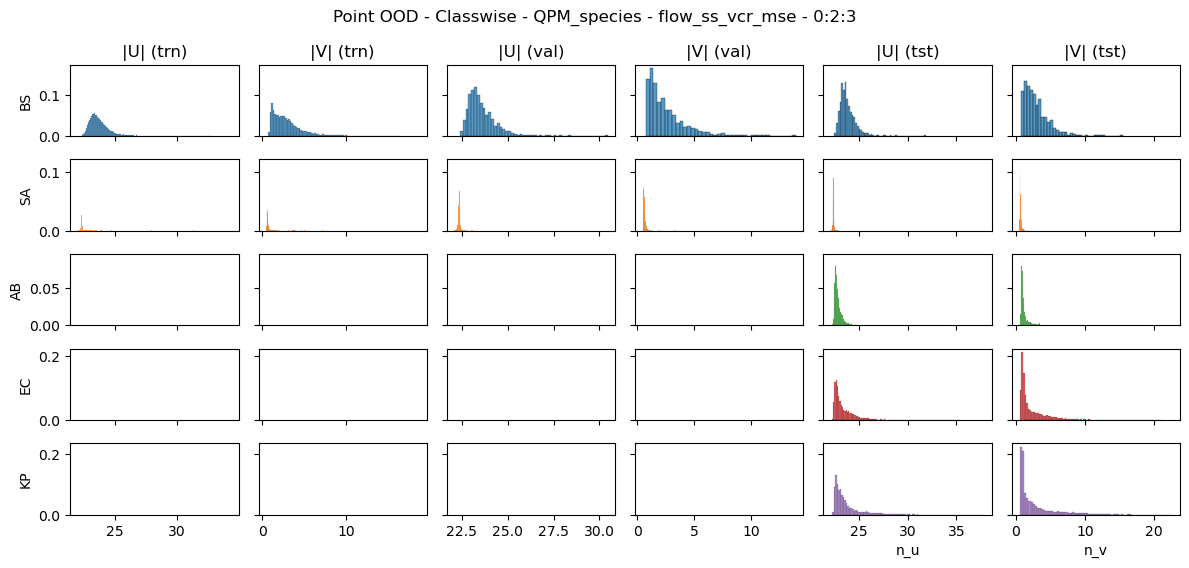

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

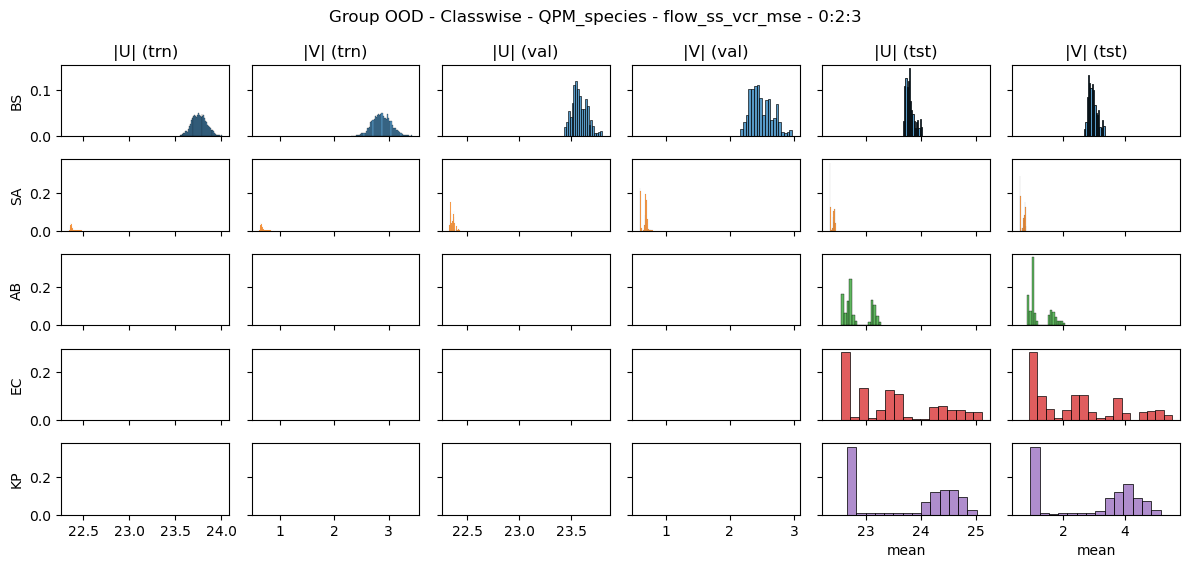

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)